# Scratch ver

import and adjust layout

In [1]:
import torch, numpy as np, pandas as pd
from torch import tensor
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

torch.manual_seed(442)

sns.set_style('whitegrid')

np.printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option("display.width", 140)

In [2]:
path = Path("./input")
train_path = path/"train.csv"
trn_df = pd.read_csv(train_path)

In [3]:
trn_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Pre-process data

### Handling missing data

In [4]:
trn_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

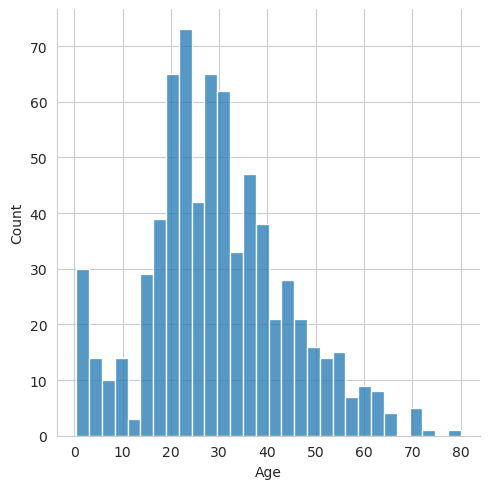

In [5]:
sns.displot(trn_df['Age'], kde=False, bins=30)

age imputation                                                                     

In [6]:
age_imputer = KNNImputer(n_neighbors=5)                                              
trn_df["Age"] = age_imputer.fit_transform(trn_df[["Age", "Pclass", "SibSp", "Parch"]])[:, 0]

handling other missing values

In [7]:
modes = trn_df.mode().iloc[0]
trn_df.fillna(modes, inplace=True)

let's look at our data

In [8]:
trn_df.describe(include=np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.828249,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.293378,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.800000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


the fare seems wired right? take a closer look at it?

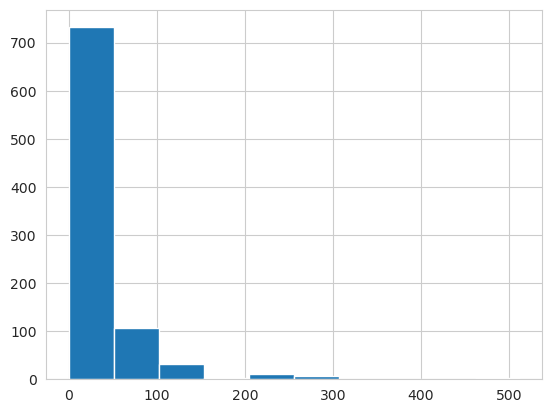

In [9]:
trn_df['Fare'].hist();

In [10]:
trn_df["LogFare"] = np.log1p(trn_df['Fare'])

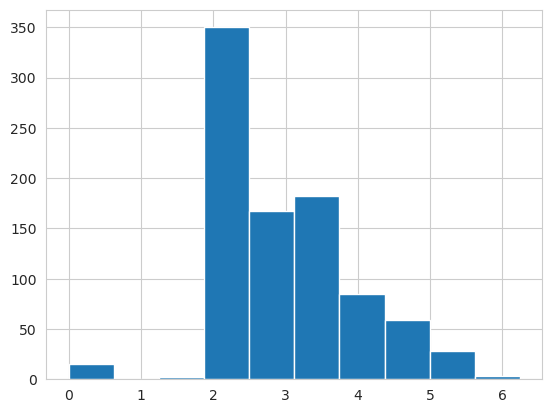

In [11]:
trn_df['LogFare'].hist();

it's look better now, let's do some feature engineering!

In [12]:
# family features
trn_df["FamilySize"] = trn_df["SibSp"] + trn_df["Parch"] + 1
trn_df["IsAlone"] = (trn_df["FamilySize"] == 1).astype(int)

<Axes: xlabel='Survived', ylabel='count'>

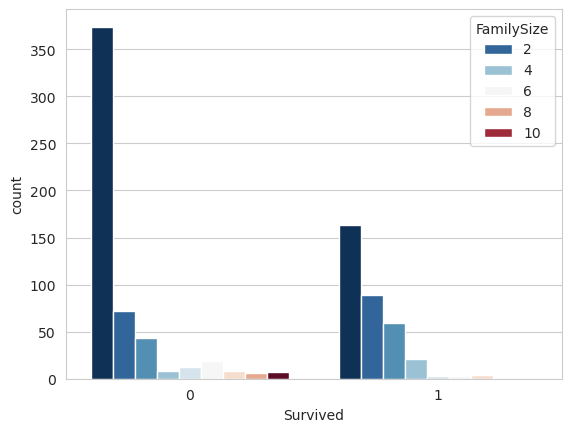

In [13]:
sns.countplot(x='Survived', data=trn_df, hue='FamilySize', palette='RdBu_r')

maybe it was hard to round up the whole crew?

"Name that title"?

In [14]:
trn_df['Title'] = trn_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
trn_df['Title'] = trn_df['Title'].replace(rare_titles, 'Rare')
trn_df['Title'] = trn_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
trn_df['Title'] = trn_df['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
trn_df['Title'] = trn_df['Title'].map(title_mapping)

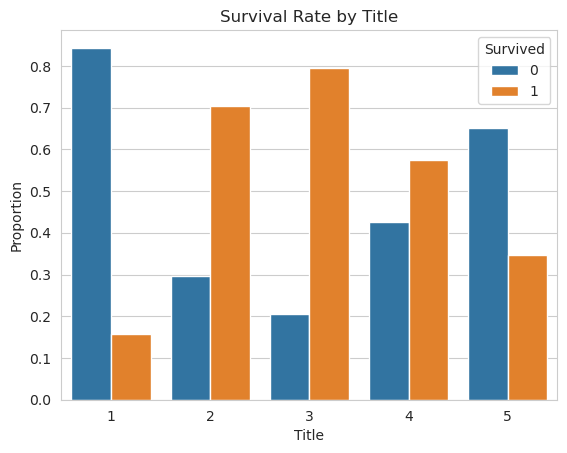

In [15]:
proportions = trn_df.groupby('Title')['Survived'].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(x='Title', y='proportion', hue='Survived', data=proportions)
plt.title('Survival Rate by Title')
plt.xlabel('Title')
plt.ylabel('Proportion')
plt.show()

poor Mr.1!

group passengers by age

In [16]:
trn_df['AgeBin'] = pd.cut(trn_df['Age'], bins=[0, 12, 20, 40, 60, np.inf], labels=[1, 2, 3, 4, 5])

one hot encode 'em

In [17]:
trn_df = pd.get_dummies(trn_df, columns=["Sex", "Pclass", "Embarked", "AgeBin"], drop_first=True, dtype=float)

a function to do this for our life easier? got you!

In [18]:
def preprocess_data(df):
    age_imputer = KNNImputer(n_neighbors=5)
    df["Age"] = age_imputer.fit_transform(df[["Age", "Pclass", "SibSp", "Parch"]])[:, 0]
    modes = trn_df.mode().iloc[0]
    df.fillna(modes, inplace=True)
    df["LogFare"] = np.log1p(df["Fare"])
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    rare_titles = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df['Title'] = df['Title'].map(title_mapping)
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, np.inf], labels=[1, 2, 3, 4, 5])
    
    # One-hot encoding
    df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked', 'AgeBin'], drop_first=True, dtype=float)
    return df

just take out the features that we're sure it's relevant the most to the survival rates, alright

In [19]:
def get_columns(name):
    return [col for col in trn_df.columns if col.startswith(name)]
added_cols = get_columns(("Sex_", "Pclass", "Embarked_", "AgeBin_"))

indep_cols = ['Title', 'Age', 'SibSp', 'Parch', 'LogFare', 'FamilySize', 'IsAlone'] + added_cols

alright we got them all, now let's make it from scratch, shall we?

In [20]:
t_indep = trn_df[indep_cols].values
t_indep

array([[ 1. , 22. ,  1. , ...,  1. ,  0. ,  0. ],
       [ 3. , 38. ,  1. , ...,  1. ,  0. ,  0. ],
       [ 2. , 26. ,  0. , ...,  1. ,  0. ,  0. ],
       ...,
       [ 2. , 28.8,  1. , ...,  1. ,  0. ,  0. ],
       [ 1. , 26. ,  0. , ...,  1. ,  0. ,  0. ],
       [ 1. , 32. ,  0. , ...,  1. ,  0. ,  0. ]])

the age seems to large let's normalize it

In [21]:
scaler = StandardScaler()
t_indep = tensor(scaler.fit_transform(trn_df[indep_cols].values), dtype=torch.float)
t_dep = tensor(trn_df["Survived"])
t_indep[:10]

tensor([[-0.7076, -0.5892,  0.4328, -0.4737, -0.8797,  0.0592, -1.2316,  0.7377, -0.5102,  0.9026, -0.3076,  0.6158, -0.3753,  0.7874,
         -0.4115, -0.1591],
        [ 1.2352,  0.6151,  0.4328, -0.4737,  1.3612,  0.0592, -1.2316, -1.3556, -0.5102, -1.1079, -0.3076, -1.6238, -0.3753,  0.7874,
         -0.4115, -0.1591],
        [ 0.2638, -0.2881, -0.4745, -0.4737, -0.7985, -0.5610,  0.8119, -1.3556, -0.5102,  0.9026, -0.3076,  0.6158, -0.3753,  0.7874,
         -0.4115, -0.1591],
        [ 1.2352,  0.3893,  0.4328, -0.4737,  1.0620,  0.0592, -1.2316, -1.3556, -0.5102, -1.1079, -0.3076,  0.6158, -0.3753,  0.7874,
         -0.4115, -0.1591],
        [-0.7076,  0.3893, -0.4745, -0.4737, -0.7842, -0.5610,  0.8119,  0.7377, -0.5102,  0.9026, -0.3076,  0.6158, -0.3753,  0.7874,
         -0.4115, -0.1591],
        [-0.7076,  0.2312, -0.4745, -0.4737, -0.7386, -0.5610,  0.8119,  0.7377, -0.5102,  0.9026,  3.2514, -1.6238, -0.3753,  0.7874,
         -0.4115, -0.1591],
        [-0.7076,  1.8

it's better to have a validation set though!

In [22]:
from fastai.data.transforms import RandomSplitter
trn_split, val_split = RandomSplitter(seed=42)(trn_df)
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]

## Our blueprint

initialize our coeff

In [23]:
def init_coeffs(n_input, n_hidden=10):
    layer_1 = torch.randn(n_input, n_hidden) / np.sqrt(n_input)
    layer_2 = torch.randn(n_hidden, 1) / np.sqrt(n_hidden)
    const = torch.rand(1)[0]
    return (layer_1.requires_grad_(), layer_2.requires_grad_(), const.requires_grad_())

function to calculate predictions

In [24]:
def calc_preds(coeffs, indep):
    l1, l2, const = coeffs
    res = F.relu(indep @ l1) 
    res = res@l2 + const
    return torch.sigmoid(res)

our loss(yeah, ur right, the felling when M.U losses!)

In [25]:
def calc_loss(coeffs, indeps, deps):
    return torch.abs(calc_preds(coeffs, indeps)-deps.float().unsqueeze(1)).mean()

what an epoch looks like?

In [26]:
def one_epoch(coeffs, lr, batch_size=64):
    n = len(trn_indep)
    for i in range(0, n, batch_size):
        batch_indep = trn_indep[i:i+batch_size]
        batch_dep = trn_dep[i:i+batch_size]
        
        loss = calc_loss(coeffs, batch_indep, batch_dep)
        loss.backward()

        with torch.no_grad():
            for layer in coeffs:
                layer.sub_(layer.grad * lr)
                layer.grad.zero_()

let's put them all together

In [27]:
def train_model(epochs=300, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs(trn_indep.shape[1])
    best_val_loss = float("inf")
    patience = 20
    counter = 0

    for epoch in range(epochs):
        one_epoch(coeffs, lr)
        with torch.no_grad():
            train_loss = calc_loss(coeffs, trn_indep, trn_dep)
            val_loss = calc_loss(coeffs, val_indep, val_dep)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_coeffs = [c.clone() for c in coeffs]
            counter = 0
        else:
            counter += 1
        
        if counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")
        lr *= 0.97  # learning rate schedule
    return best_coeffs

let's see how it will go!

In [28]:
def acc(coeffs): 
    return (val_dep.bool() == (calc_preds(coeffs, val_indep) > 0.5).squeeze()).float().mean()

coeffs = train_model(epochs=50, lr=1) 
print(f"Validation Accuracy: {acc(coeffs):.4f}")

Epoch 0: Train Loss 0.3485, Val Loss 0.3620
Epoch 5: Train Loss 0.1921, Val Loss 0.1934
Epoch 10: Train Loss 0.1819, Val Loss 0.1850
Epoch 15: Train Loss 0.1775, Val Loss 0.1805
Epoch 20: Train Loss 0.1739, Val Loss 0.1783
Epoch 25: Train Loss 0.1715, Val Loss 0.1771
Epoch 30: Train Loss 0.1702, Val Loss 0.1759
Epoch 35: Train Loss 0.1693, Val Loss 0.1750
Epoch 40: Train Loss 0.1686, Val Loss 0.1744
Epoch 45: Train Loss 0.1680, Val Loss 0.1741
Validation Accuracy: 0.8315


the results are in!

In [29]:
tst_df = pd.read_csv(path/"test.csv")
tst_df = preprocess_data(tst_df)

tst_indep = torch.tensor(tst_df[indep_cols].values, dtype=torch.float)
# Scale test data using the same scaler
tst_indep = torch.tensor(scaler.transform(tst_indep), dtype=torch.float)

# Make predictions
tst_df['Survived'] = (calc_preds(coeffs, tst_indep)>0.5).int()

In [30]:
sub_df = tst_df[['PassengerId', 'Survived']]
print(sub_df["Survived"].sum())
print(sub_df["Survived"].value_counts())

149
Survived
0    269
1    149
Name: count, dtype: int64


reasonable huh?

In [31]:
sub_df.to_csv("sub.csv", index=False)

In [32]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


with this one i got uh, i forgot it, damnit! i think it's like 0.77 acc

i think it did pretty good for a model building from scratch, didn't it? let's improve it, shall we?